#### *If you are not interested in how the models work or do not plan to customize the code, jump to the <a href='#run-section'>"Run Code"</a> section.*

In [1]:
import random
from collections import Counter
from sklearn import metrics
import sklearn_crfsuite
from nltk import HiddenMarkovModelTagger as hmm
import matplotlib.pyplot as plt
import numpy as np
import string
import itertools
import datetime
import re

### Data Helper Functions

In [2]:
def predictFile(tuple_dataset, modelname, tagged=True):
    '''write data sets to files for printing and sharing
    Do not include if data is supposed to be unannotated/tagged'''
    
    datastring = []
    for sent in tuple_dataset:
        sentence = []
        for pair in sent:
            if tagged:
                sentence.append(pair[0] + '/' + pair[1])
            else: 
                sentence.append(pair[0])
        datastring.append(' '.join(sentence))

    with open(DATA_FOLDERPATH+ITERATION+'.predict', 'w') as T:
        T.write('\n'.join(datastring))

In [3]:
def extractData(filepath, tagged=True):
    '''Get data from files and format for training & testing and predictions'''
    
    with open(filepath) as file:
        sentencestrings = [line.strip() for line in file]
    
    formatted_data = []
    for sent in sentencestrings:
        sentence = []
        for element in sent.split():
            if tagged:
                pair = element.split('/')
                sentence.append((pair[0], pair[1]))
            else: 
                sentence.append((element, 'X'))
        formatted_data.append(sentence)

    return formatted_data

In [4]:
def prepare(modelname, message):
    
    # read from files
    train = extractData(DATA_FOLDERPATH+ITERATION+'.train')
    test = extractData(DATA_FOLDERPATH+TESTNAME+'.test')
    untag = extractData(DATA_FOLDERPATH+PREVITERATION+modelname+'.predict', tagged=False)
    
    # get log info
    train_tokens, untag_tokens, train_tag_freq, traintags = get_stats(train,untag)
    
    logstring = str(datetime.datetime.now()) + '\n\n' + message
    logstring+= "\nTrain tokens: {}.\nUnannotated tokens: {}.\n\nPOS tags in train set:\n\n".format(train_tokens, untag_tokens)
    for tag,freq in train_tag_freq.items():
        logstring+=tag + '   \t' + str(freq) + '\n'
    
    with open(LOG_FOLDERPATH+ITERATION+'.log', 'w') as logf:
        logf.write(logstring)
        
    return train, test, untag, traintags

In [5]:
def get_stats(traindata, untaggeddata):
    untagged_tokens = sum(len(sent) for sent in untaggeddata)
    train_tokens = sum(len(sent) for sent in traindata)
    train_tags = [tag for sent in traindata for word,tag in sent]
    
    return sum(len(sent) for sent in untaggeddata), sum(len(sent) for sent in traindata), Counter(train_tags), list(set(train_tags))

# POS Taggers 

This code allows us to train three machine learning models to do POS tagging. With each model, we take the same three basic steps.

1) Train the model. The models use some statistical patterns or features of the training data with its POS tags to build a predictive model. 

2) Use the trained model to predict POS tags over the test sentences. Then compare those predictions to the correct tags and produce evaluation metrics for that model. We use precision, recall, F1 scores, and a confusion matrix.

3)  Predict tags over our unannotated sentences. Then sort these sentences based on the model's "confidence" in those predictions. That is, the probabilities that the POS tagger computed for that particular sequence of labels. A higher aggregate probablity == higher confidence in the predicted sequence of POS tags. 

### Helper Functions
Here are some functions that will be handy later. The `cm` function builds and display a confusion matrix so we can evaluate where our tagger is making wrong predictions, after we test a POS tagger. The `sort_predictions` function sorts our previously unannotated sentence based on how "confident" the model was at it predictions of each sentence's POS tags.

In [6]:
def cm(gold_tags, predicted_tags, taglist, modelname):
    # confusion matrix
    alpha_taglist = sorted(set(taglist))
    confusion_matrix = metrics.confusion_matrix(gold_tags,predicted_tags,labels=alpha_taglist,normalize="true")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix,display_labels=alpha_taglist)

    plt.rcParams["figure.figsize"] = (10,10)
    plt.rcParams.update({'font.size': 12})
    disp.plot(colorbar=False)
    plt.show() # display below
    plt.savefig(LOG_FOLDERPATH+ITERATION+modelname+'_matrix.png')    #save as file
    
    
    matrixstring = '{0:5s}'.format(' ') + '\t'.join(['{0:^4s}'.format(tag) for tag in alpha_taglist]) + '\n'
    for i,row in enumerate(confusion_matrix):
        cols = '\t'.join(['{:.2f}'.format(round(col,2)) for col in row])
        matrixstring+='{0:6s}'.format(alpha_taglist[i]) + cols + '\n'
    
    return matrixstring

    
def logResults(classreport, confusion, modelname):
    with open(LOG_FOLDERPATH+ITERATION+modelname+'.results', 'w') as R:
        time = str(datetime.datetime.now())
        report = '\n\nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(classreport, confusion)
        R.write(time + report)
        
    
def sort_predictions(w_t_predictions, seq_confidences_scores, modelname):
    '''sort auto-annotated sentences by decreasing "confidence",
    i.e., lower probability == less confidence. Write to File.
    '''
    with_confidence = list(zip(w_t_predictions, seq_confidences_scores))
    with_confidence.sort(key = lambda x: x[1])
    sorted_sequences = [z[0] for z in with_confidence]
    predictFile(sorted_sequences, modelname)

## Model "HMM" - Hidden Markov Model

The first model we can try is a simple Hidden Markov Model (HMM). HMM is a probablistic (stochastic) approach. It will calculate the probability associated with a particular sequence of POST tags. It uses two features of the data to build and weight the probabilities. These features become the Transition probability and Emission probability.

The transition probability is computed by counting the how many times a POS X follows POS Y. These counts can be used as the likelihood that, for example, a noun is preceded by a verb and the verb preceded by an adjective, etc.

The emission probability computed by counting how many times a given word is tagged as any POS. These counts are used to predict the likelihood that a word is a certain part of speech. For example, how likely is the word "box" a noun, "will" is a verb, "spot" is a verb, and "Will" is a noun. 

In [7]:
def mainHMM(modelname):
    
    traindata, testdata, untagged_set, tags = prepare(modelname, NOTES)
    
    ###Training
    tagger = hmm.train(traindata)
    
    # Get gold standard tags from test dataset
    test_tags = [tag for sent in testdata for word,tag in sent] 
    
    ###Testing
    test_output=[]
    for sentence in testdata:
        words = [word for word,_ in sentence]
        test_output+=[tag for _,tag in tagger.tag(words)]
        
    # test reports
    scores = metrics.classification_report(test_tags, test_output, zero_division=0.0)
    matrix = cm(test_tags, test_output, tags, modelname)
    logResults(scores, matrix, modelname)
    
    # Generate tags for untagged data
    predicted_sequences = []
    probabilities = []
    for sentence in untagged_set:
        words = [word for word,_ in sentence]
        predictions = tagger.tag(words)
        probabilities.append(tagger.log_probability(predictions)/len(words))
        predicted_sequences.append(predictions)
        
    sort_predictions(predicted_sequences, probabilities, modelname)

## Model "CRFsimple" - Conditional Random Fields (CRF) with Lots of Features

A CRF is a sequence modeling algorithm useful for identifying entities or patterns in text, such as POS tags. This model assumes that features are dependent on each other, and it is able to consider future observations while learning a pattern. 

Machine learning models take into account previous data. We must feed into the CRF features from the data. The algorithm will create a predictive, probablistic model from these features. The word2features function below extracts features that characterize the data point, such as the sequence of previous words.

This model has several good and tested features for POS tagging. It take from: https://towardsdatascience.com/pos-tagging-using-crfs-ea430c5fb78b#1c6a.

In [8]:
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word': word,
        'len(word)': len(word),
        'word[:4]': word[:4],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[-4:]': word[-4:],
        'word.lower()': word.lower(),
        'word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word.lower()),
        'word.ispunctuation': (word in string.punctuation),
        'word.isdigit()': word.isdigit()}
    
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word': word1,
            '-1:len(word)': len(word1),
            '-1:word.lower()': word1.lower(),
            '-1:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word1.lower()),
            '-1:word[:3]': word1[:3],
            '-1:word[:2]': word1[:2],
            '-1:word[-3:]': word1[-3:],
            '-1:word[-2:]': word1[-2:],
            '-1:word.isdigit()': word1.isdigit(),
            '-1:word.ispunctuation': (word1 in string.punctuation)})     
    else:
        features['BOS'] = True

    if i > 1:
        word2 = sent[i-2][0]
        features.update({
            '-2:word': word2,
            '-2:len(word)': len(word2),
            '-2:word.lower()': word2.lower(),
            '-2:word[:3]': word2[:3],
            '-2:word[:2]': word2[:2],
            '-2:word[-3:]': word2[-3:],
            '-2:word[-2:]': word2[-2:],
            '-2:word.isdigit()': word2.isdigit(),
            '-2:word.ispunctuation': (word2 in string.punctuation),
        })

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word': word1,
            '+1:len(word)': len(word1),
            '+1:word.lower()': word1.lower(),
            '+1:word[:3]': word1[:3],
            '+1:word[:2]': word1[:2],
            '+1:word[-3:]': word1[-3:],
            '+1:word[-2:]': word1[-2:],
            '+1:word.isdigit()': word1.isdigit(),
            '+1:word.ispunctuation': (word1 in string.punctuation),
        })

    else:
        features['EOS'] = True    
    
    if i < len(sent) - 2:
        word2 = sent[i+2][0]
        features.update({
            '+2:word': word2,
            '+2:len(word)': len(word2),
            '+2:word.lower()': word2.lower(),
            '+2:word.stemmed': re.sub(r'(.{2,}?)([aeiougyn]+$)',r'\1', word2.lower()),
            '+2:word[:3]': word2[:3],
            '+2:word[:2]': word2[:2],
            '+2:word[-3:]': word2[-3:],
            '+2:word[-2:]': word2[-2:],
            '+2:word.isdigit()': word2.isdigit(),
            '+2:word.ispunctuation': (word2 in string.punctuation),
        })

    return features

In [9]:
# words and labels, feed words to feature extractor
def sent2features(sent, customfeatures):
    if customfeatures:
        return [custom_word2features(sent, i) for i in range(len(sent))]
    else:
        return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [word[1] for word in sent]

def sent2tokens(sent):
    return [word[0] for word in sent]

In [10]:
def mainCRF(modelname, custom=True):
    
    traindata, testdata, untagged_set, tags = prepare(modelname, NOTES)
    
    # extracting features from all the sentences
    train_ftrs = [sent2features(s, custom) for s in traindata]
    train_tags = [sent2labels(s) for s in traindata]

    test_ftrs = [sent2features(s, custom) for s in testdata]
    test_tags = [sent2labels(s) for s in testdata]
    
    unannotated_ftrs = [sent2features(s, custom) for s in untagged_set]
    unannotated_words = [sent2tokens(s) for s in untagged_set]
    
    # training
    crf = sklearn_crfsuite.CRF(
        algorithm = 'lbfgs',
        c1 = 0.25,
        c2 = 0.3,
        max_iterations = 100,
        all_possible_transitions=True)
    
    crf.fit(train_ftrs, train_tags)
    
    # testing
    test_output = crf.predict(test_ftrs)
    # test reports
    test_tags = list(itertools.chain.from_iterable(test_tags))
    test_output = list(itertools.chain.from_iterable(test_output))
    scores = metrics.classification_report(test_tags, test_output, zero_division=0.0)
    matrix = cm(test_tags, test_output, tags, modelname)
    logResults(scores, matrix, modelname)
    
    # predict
    predicted_labels = crf.predict(unannotated_ftrs)
    predicted_sequences = [list(zip(unannotated_words[i],predicted_labels[i])) for i in range(len(predicted_labels))]
    all_probs = crf.predict_marginals(unannotated_ftrs)
    
    confidences = []
    for s,sent in enumerate(predicted_sequences):
        confidences.append(sum([all_probs[s][i][pair[1]] for i,pair in enumerate(sent)])/len(sent))
    
    sort_predictions(predicted_sequences, confidences, modelname)

## Model "CRFcustom" - Conditional Random Fields (CRF) to be Customized

This model is the same as the second except that it allows you to customize the code to extract your own chosen features. It uses much of the same code as the CRFsimple model, except for the feature extraction code which you can customize in `custom_word2features` below.  To start you off, a small number of features are included: the "bias" feature (always included), the previous token, the next token, the token itself, and whether the token is punctuation or a digit. 

Feel free to experiment with the features and add new ones to see which combination gives the most accuracy. If you get stuck for ideas, see this article: https://towardsdatascience.com/pos-tagging-using-crfs-ea430c5fb78b#1c6a.

**Keep track of the features you add to each retraining iteration in the log files!** 

In [11]:
# customize the first for the CRFcustom model here
def custom_word2features(sent, i):
    word = sent[i][0]

    features = {
            'bias': 1.0,
            'word': word,
            'word.ispunctuation': (word in string.punctuation),
            'word.isdigit()': word.isdigit()
            }

    # extract features from previous words 
    if i > 0: # word is not first word in sentence
        prevword = sent[i-1][0]
        features.update({
            '-1:word': prevword,
           })
    else: # word is first word in sentence
        features['BOS'] = True

    # extract features from succeeding words
    if i < len(sent)-1: # not last word in sentence
        nextword = sent[i+1][0]
        features.update({
            '+1:word': nextword,
        })
    else: # is last token in sentence
        features['EOS'] = True
    
    return features

<h1 id="run-section">Run Code</h1>

During the Machine-in-the-Loop activity help team members through these steps.

    1) Form teams
    2) Analyse Errors:
        -- Examine evaluation metrics and confusion matrix in the display or the `.results' file.
    3) Preprocess training data and/or CRFcustom code to improve Previous Model:
        -- Make any changes to train data and unannotated file
        -- Change .train and .predict filenames.
        -- Code any customized model features in custom_word2features()
        -- Make note of changes or other comments.
    4) Adjust and prepare to run code that trains new model:
        -- Update `ITERATION` variable (first time only: update RESULTS_ and DATA_ folder path variables).
        -- Add note of changes or other comments in `NOTES` variable.
    5) Train, test, predict:
        -- Run the `main` function for chosen model. 
        -- Eyeball log file. Edit notes
        -- Eyeball files in `results/` folder
        -- Debug and rerun code if something seems off in those files.
    6) Rinse and repeat

#### IMPORTANT Notes about Data and Files

- Start with the initial training data set in files prefixed as `DIU_origin0`. All the data was randomly extracted from the Brown Corpus via [nltk](https://www.nltk.org/book/ch05.html). To imitate typical "noisy" field data, about portion of the training tokens were given random POS tags. 

- The three data sets are stored in files (with extensions: `.train`, `.test`, `.predict`) for easy printing and sharing. Workshop participants can make changes to these data files, except the test data. Changes should be changed in new files with **the same file extensions!** These changed data will be used to train a new (and better?) POS tagger. 

- **Do not change the test data files!** These all have the correct POS tags.

- A 5500 words were taken from the Brown corpus without POS tags to simulate field data that has not been annotated yet. Every time a new POS taggers is trained, these sentences will be auto-tagged and should be written to a file. It is recommended, but not necessary that when team members correct these tags and add the corrected sentences+tags to the .train file. 

- A `.log` file will be written for every training iteration with the data statistics for that iteration. The changing statistics will show the effect of data size, and other changes made to the training data. The log will be automatically filled in with the number of training tokens, the list and number of each POS tag in the training data.  **Please document any changes made since the last iteration which are not tracked with this code (e.g. "30 tags were corrected in the training data")**

## 1. Update File Names and Log

In [12]:
''' File naming key: DIU_<team><iteration#>_<modelname>
    File Extensions:
     .train --> training data
     .test --> test data
     .predict --> unannotated data to be auto-annotated'''

PREVITERATION = 'DIU_Skynet1'
ITERATION = 'DIU_Skynet2'
TESTNAME = 'DIU_origin0'
DATA_FOLDERPATH = './data/'
LOG_FOLDERPATH = './reports/'

NOTES = ''

## 2. Run Model(s)

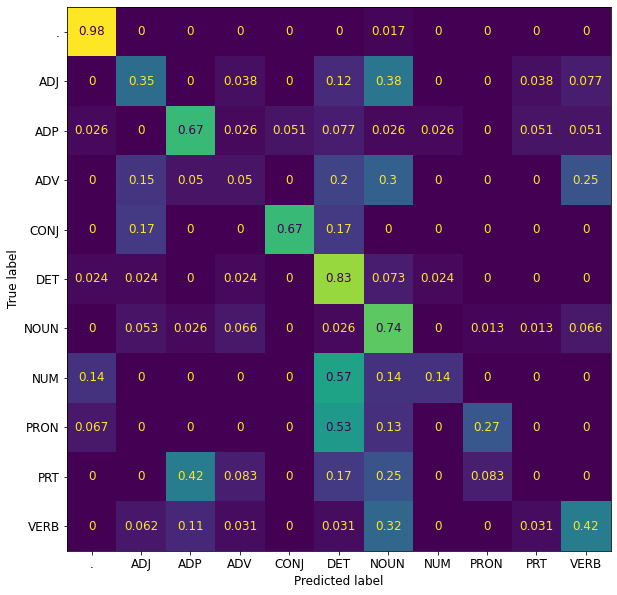

<Figure size 720x720 with 0 Axes>

In [14]:
mainCRF('_CRFsimple', custom=False)

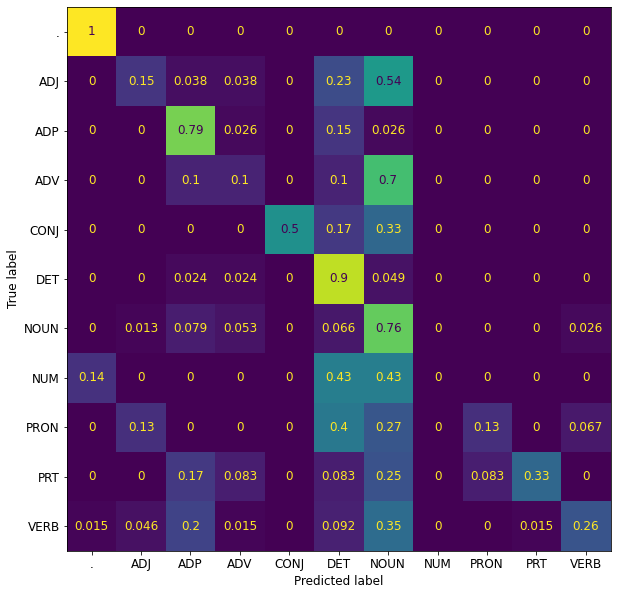

<Figure size 720x720 with 0 Axes>

In [15]:
mainCRF('_CRFcustom')

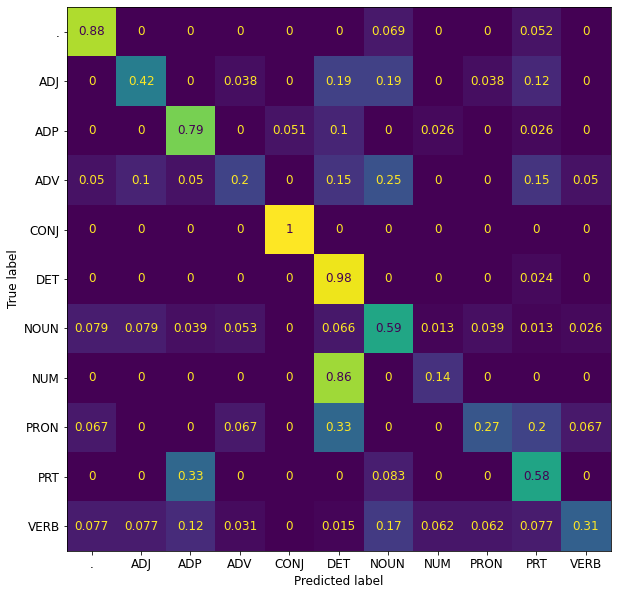

<Figure size 720x720 with 0 Axes>

In [16]:
mainHMM('_HMM')